# Exploratory Data Analysis

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Reading sensor files

In [2]:
files = [file for file in os.listdir('../../Processed Sensors')]
files.sort()
read_files = []
for file in files:
    read_files.append(pd.read_csv('../../Processed Sensors/' + file))

### Removing sensors that don't appear across every user run

In [3]:
cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]
common_els = reduce(set.intersection, (set(item) for item in cols_file))
common_els = list(common_els)
read_files = [read_files[i][common_els] for i in range(len(read_files))]

### Reading the downtime data file and filtering out onlt the ion source failures

In [4]:
downtimeNew = pd.read_excel('../../Raw Data/Equipment downtime data (202310).xlsx')
downtimeNew['FaultDate'] = pd.to_datetime(downtimeNew['FaultDate'], errors='coerce').dt.date
downtimeNew['FaultTime'] = downtimeNew['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)
downtimeNew = downtimeNew.dropna(subset=['FaultDate', 'FaultTime'])
pattern_new = downtimeNew.iloc[:, :14]
pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)
pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))
pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)
pattern_new.sort_values(by=['FaultDateTime'], inplace=True)
pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)
pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')
pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

### Integrating the fail points in the sensor files

In [5]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']
isrcFailRuns = [pattern_new[pattern_new['User Run'] == ur] for ur in userruns]

ct = 0
for i in range(len(read_files)):
    read_files[i]['Label'] = -1
    read_files[i]['failCount'] = ct
    read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
    for j in range(read_files[i].shape[0]-1):
        read_files[i].loc[j, 'failCount'] = ct
        read_files[i].loc[j+1, 'failCount'] = ct
        for el in isrcFailRuns[i]['FaultDateTime']:
            if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                read_files[i].loc[j, 'Label'] = 0   #['Label'][j] = 1
                ct+=1
                break

### Describe

In [6]:
print(read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])].describe())

       irfq::ext:read_current  irfq::solenoid_1:read_current_ra  \
count            74881.000000                      74881.000000   
mean                 4.254338                        353.821857   
std                  0.612007                          4.211600   
min                 -0.000610                        288.990021   
25%                  4.415184                        351.538522   
50%                  4.528751                        351.538522   
75%                  4.528751                        351.538522   
max                  7.526939                        365.749023   

       irfq::arc_ac:set_current  irfq::trigger_1:delp  irfq::mag_on:sta  \
count              74881.000000          74881.000000      74881.000000   
mean                  55.794958            930.998598          0.954928   
std                    2.926024              0.037420          0.207462   
min                    0.000000            930.000000          0.000000   
25%                  

### Plotting the sensor value change as bar plots 

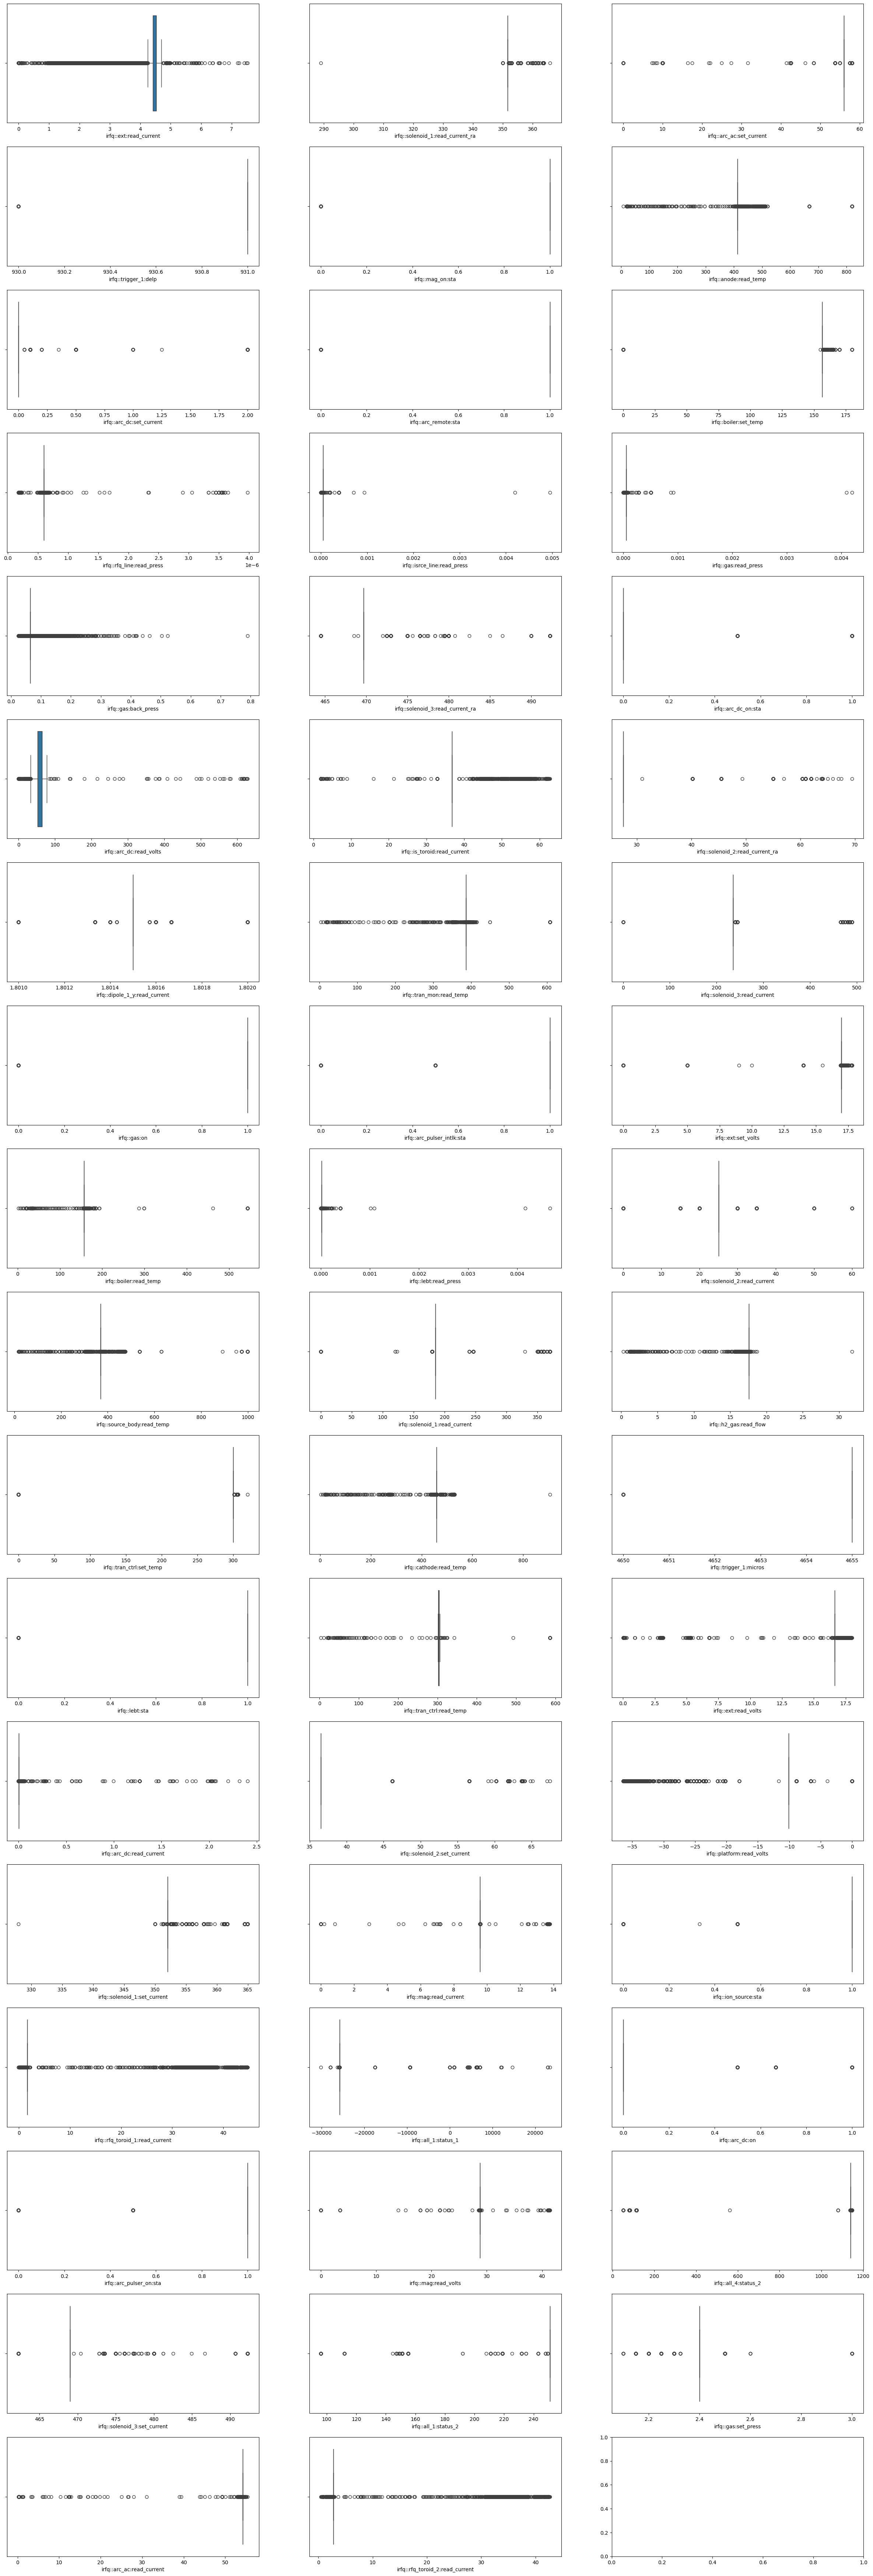

In [7]:
data = read_files[0].copy()

fig, ax = plt.subplots(18, 3,figsize=(30, 90))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.boxplot(data=data, x = column, ax=ax.ravel()[i])

/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_10649/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_10649/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_10649/3532922237.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)
/var/folders/fy/y84g2yps4c9br5q9c1rlvy2h0000gn/T/ipykernel_10649/3532922237.

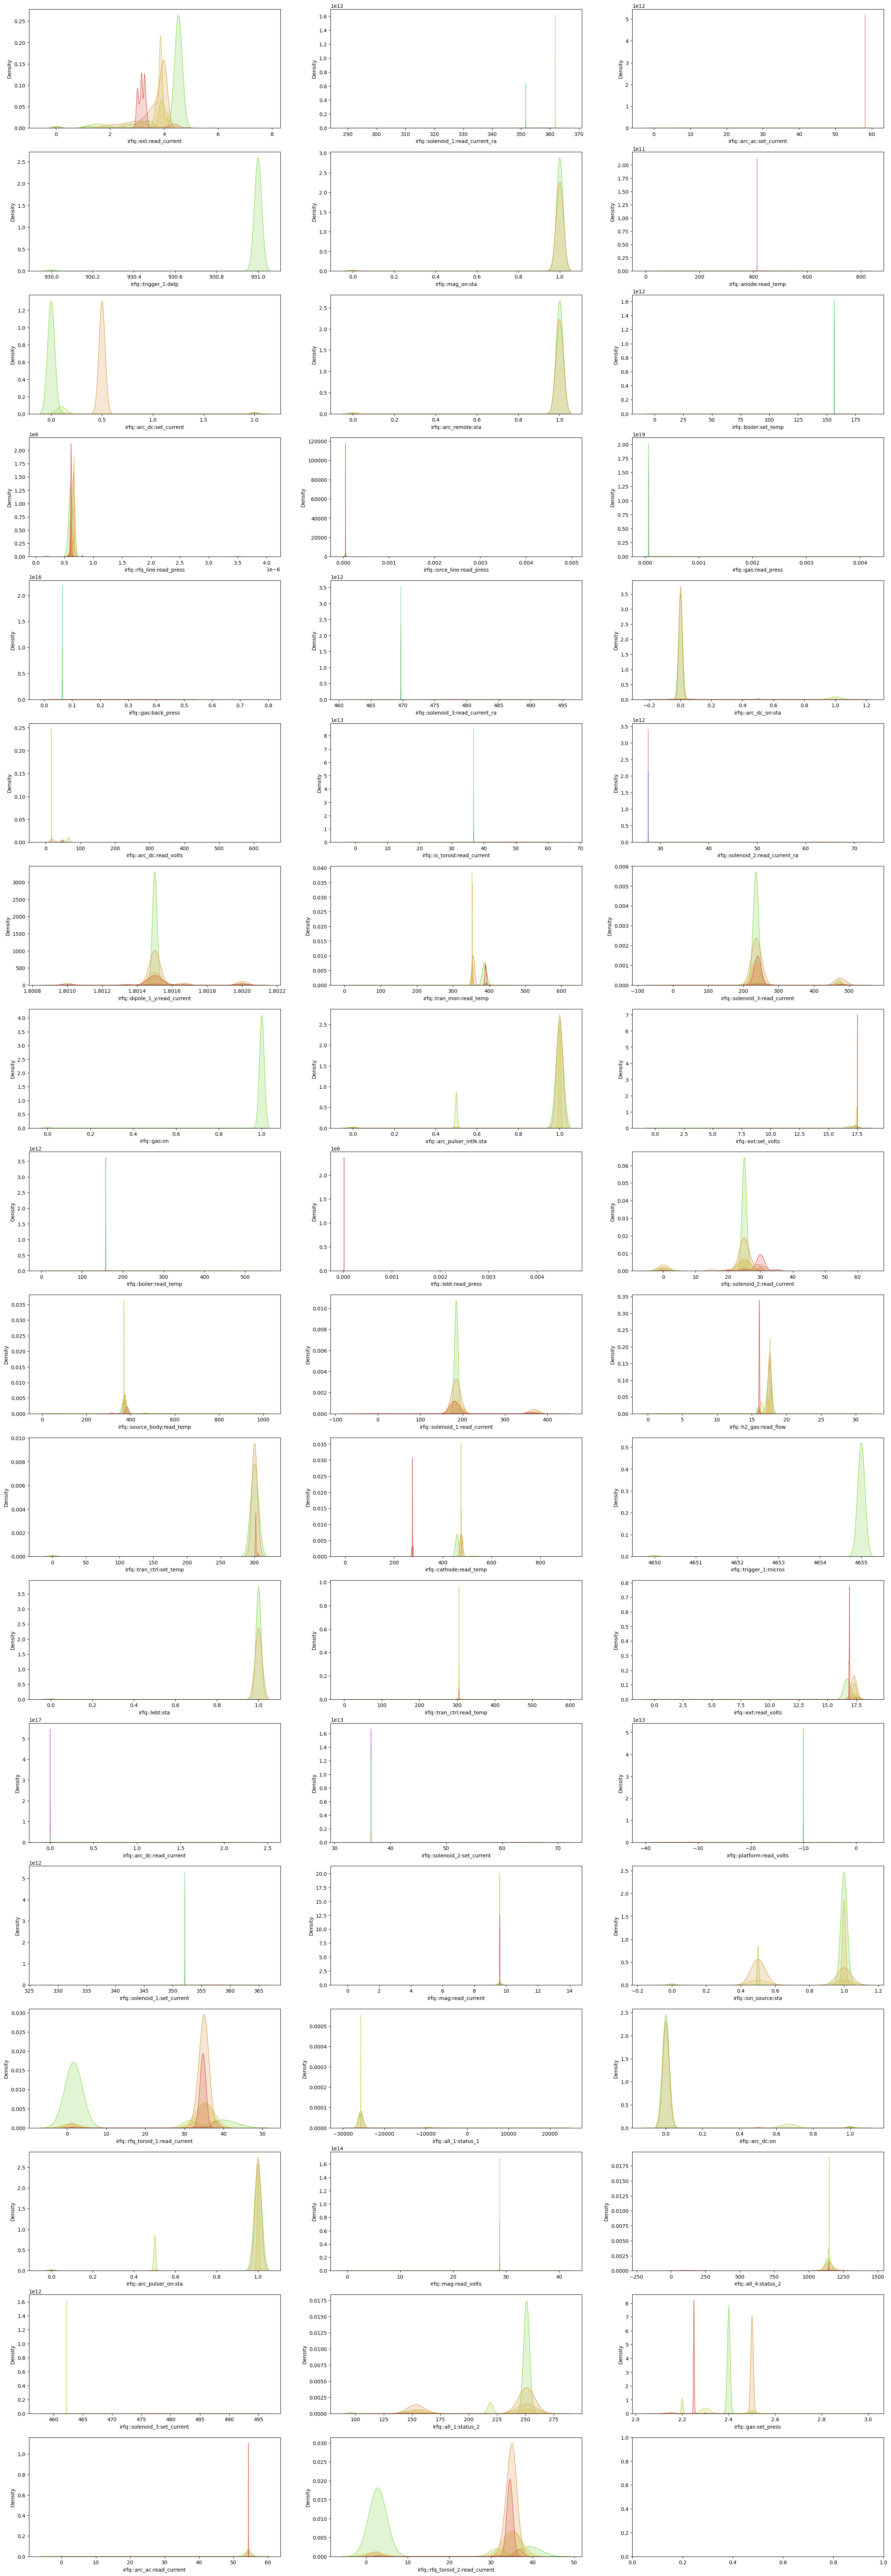

In [8]:
fig, ax = plt.subplots(18, 3,figsize=(30, 90))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)

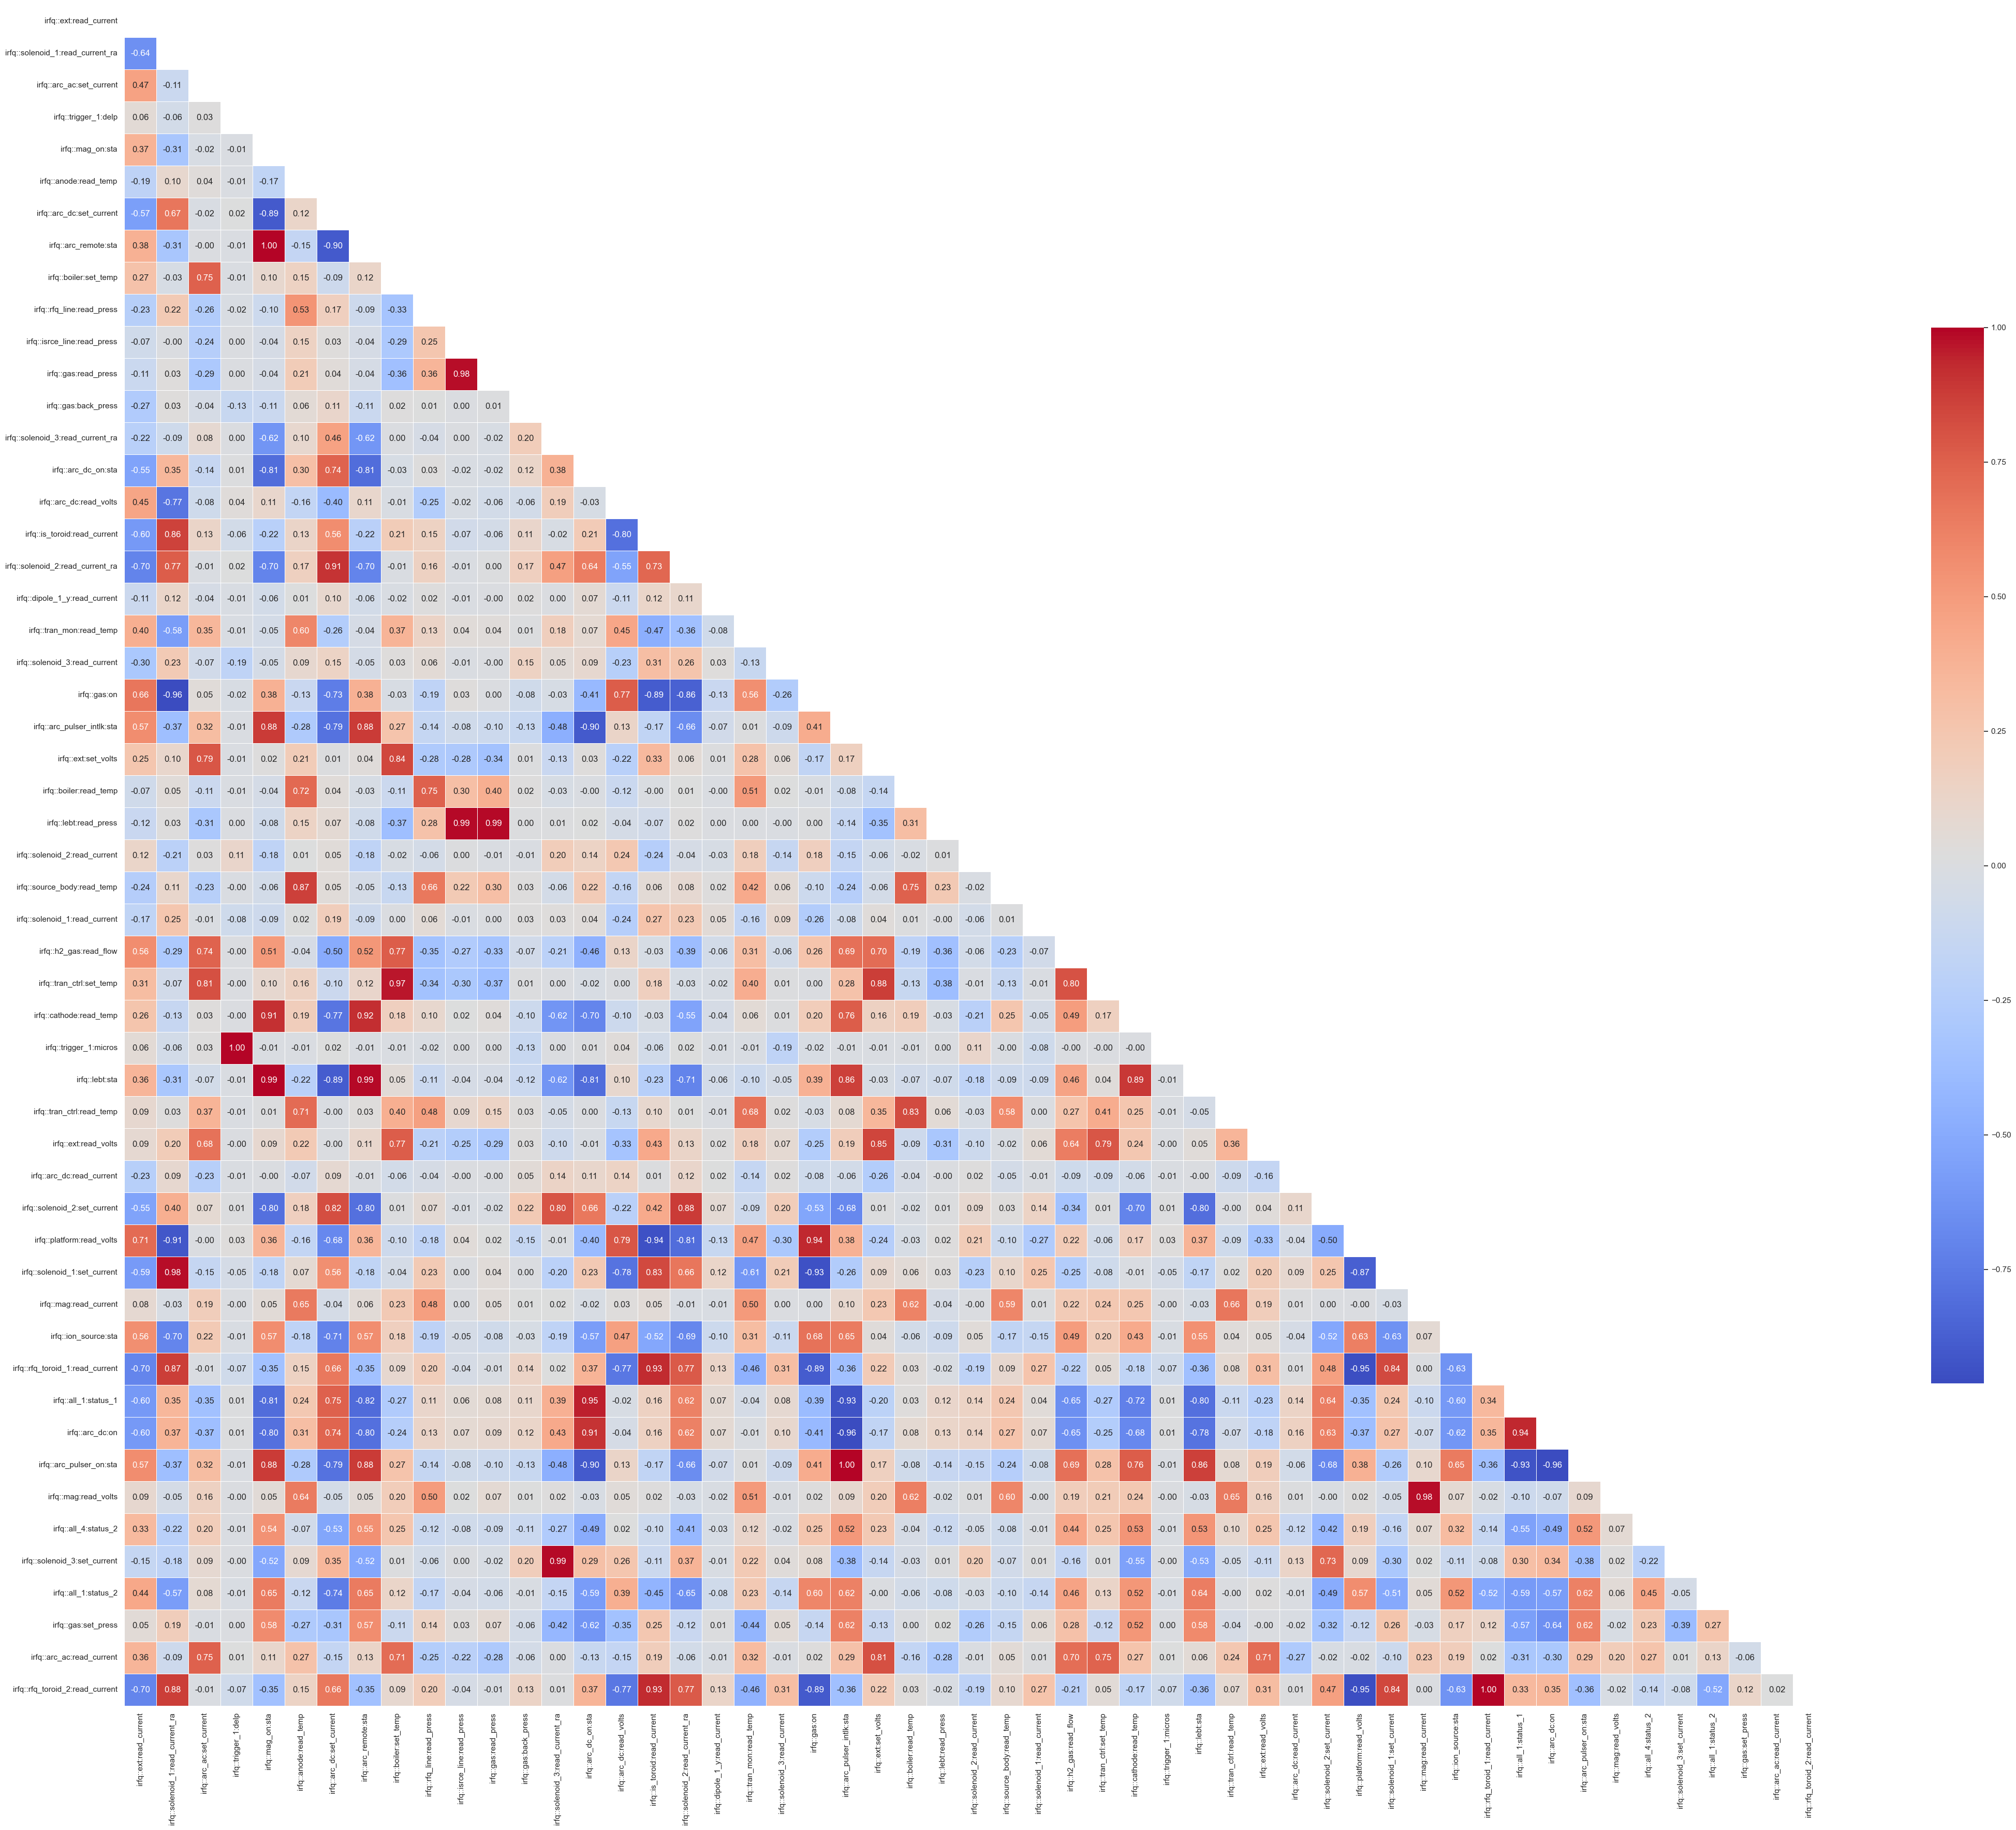

In [9]:
data = read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])]

corr = data.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(53, 53))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [15]:
corr_matrix = data.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop_neg = [column for column in upper_tri.columns if any(upper_tri[column] < -0.9)]

print(len(to_drop), to_drop)
print(len(to_drop_neg),to_drop_neg)

sett = set(to_drop + to_drop_neg)

17 ['irfq::arc_remote:sta', 'irfq::gas:read_press', 'irfq::solenoid_2:read_current_ra', 'irfq::lebt:read_press', 'irfq::tran_ctrl:set_temp', 'irfq::cathode:read_temp', 'irfq::trigger_1:micros', 'irfq::lebt:sta', 'irfq::platform:read_volts', 'irfq::solenoid_1:set_current', 'irfq::rfq_toroid_1:read_current', 'irfq::all_1:status_1', 'irfq::arc_dc:on', 'irfq::arc_pulser_on:sta', 'irfq::mag:read_volts', 'irfq::solenoid_3:set_current', 'irfq::rfq_toroid_2:read_current']
8 ['irfq::gas:on', 'irfq::platform:read_volts', 'irfq::solenoid_1:set_current', 'irfq::rfq_toroid_1:read_current', 'irfq::all_1:status_1', 'irfq::arc_dc:on', 'irfq::arc_pulser_on:sta', 'irfq::rfq_toroid_2:read_current']


In [16]:
print(len(sett), sett)

18 {'irfq::all_1:status_1', 'irfq::gas:read_press', 'irfq::arc_dc:on', 'irfq::trigger_1:micros', 'irfq::arc_pulser_on:sta', 'irfq::lebt:sta', 'irfq::solenoid_2:read_current_ra', 'irfq::rfq_toroid_2:read_current', 'irfq::mag:read_volts', 'irfq::solenoid_3:set_current', 'irfq::arc_remote:sta', 'irfq::gas:on', 'irfq::lebt:read_press', 'irfq::platform:read_volts', 'irfq::solenoid_1:set_current', 'irfq::cathode:read_temp', 'irfq::tran_ctrl:set_temp', 'irfq::rfq_toroid_1:read_current'}


In [11]:
actual_data = read_files.copy()
actual_data
for i in range(len(actual_data)):
    actual_data[i].drop(to_drop, axis=1, inplace=True)

In [12]:
actual_data[0]

,irfq::ext:read_current,irfq::solenoid_1:read_current_ra,irfq::arc_ac:set_current,irfq::trigger_1:delp,irfq::mag_on:sta,irfq::anode:read_temp,irfq::arc_dc:set_current,Time,irfq::boiler:set_temp,irfq::rfq_line:read_press,...,irfq::arc_dc:read_current,irfq::solenoid_2:set_current,irfq::mag:read_current,irfq::ion_source:sta,irfq::all_4:status_2,irfq::all_1:status_2,irfq::gas:set_press,irfq::arc_ac:read_current,Label,failCount
0,3.126547,355.999023,58.064459,931.0,0.0,444.446014,2.0,2019-02-05 08:30:00,158.000000,6.150000e-07,...,0.00366,61.833333,9.58676,0.5,115.0,151.0,2.25,54.252291,-1,0
1,3.129876,355.999023,58.064459,931.0,0.0,444.385014,2.0,2019-02-05 08:31:00,158.000000,6.150000e-07,...,0.00366,61.833333,9.58188,0.5,115.0,151.0,2.25,54.276986,-1,0
2,3.133478,355.999023,58.064459,931.0,0.0,444.446014,2.0,2019-02-05 08:32:00,158.000000,6.150000e-07,...,0.00366,61.833333,9.58432,0.5,115.0,151.0,2.25,54.273225,-1,0
3,3.132096,355.999023,58.064459,931.0,0.0,444.421613,2.0,2019-02-05 08:33:00,158.000000,6.150000e-07,...,0.00366,61.833333,9.58188,0.5,115.0,151.0,2.25,54.301386,-1,0
4,3.134945,355.999023,58.064459,931.0,0.0,444.463444,2.0,2019-02-05 08:34:00,158.000000,6.150000e-07,...,0.00366,61.833333,9.58188,0.5,115.0,151.0,2.25,54.266820,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74876,4.528751,351.538522,56.000000,931.0,1.0,413.091980,0.0,2019-03-29 08:26:00,156.333333,6.000000e-07,...,0.00122,36.511111,9.58676,1.0,1139.0,251.0,2.40,54.241199,-1,23
74877,4.528751,351.538522,56.000000,931.0,1.0,413.091980,0.0,2019-03-29 08:27:00,156.333333,6.000000e-07,...,0.00122,36.511111,9.58676,1.0,1139.0,251.0,2.40,54.241199,-1,23
74878,4.528751,351.538522,56.000000,931.0,1.0,413.091980,0.0,2019-03-29 08:28:00,156.333333,6.000000e-07,...,0.00122,36.511111,9.58676,1.0,1139.0,251.0,2.40,54.241199,-1,23
74879,4.528751,351.538522,56.000000,931.0,1.0,413.091980,0.0,2019-03-29 08:29:00,156.333333,6.000000e-07,...,0.00122,36.511111,9.58676,1.0,1139.0,251.0,2.40,54.241199,-1,23


takes roughly >15mins